

In the `explore()` method:

1. We reshape the `historical_orders_array` to have `product_id` as the first dimension using `reshape()`. This allows us to easily perform calculations and plotting for each product.

2. We calculate the total quantity sold for each product using `total_quantity_sold = reshaped_array.sum(axis=0)`.

3. We find the top 10 most sold products using `total_quantity_sold.argsort()[-10:][::-1]`.

4. We plot the number of items sold over the weeks for the top 10 products using `plt.plot()`.

5. To find items with seasonality, we iterate over each product and check if the maximum quantity sold is greater than 0 and the minimum quantity sold is 0. Products satisfying this condition are considered seasonal.

6. We plot the seasonality of the identified products using `plt.plot()`.

7. As additional data exploration, we plot the total quantity sold for each product using `plt.bar()`.

8. We calculate and plot the average quantity sold per week for each product using `reshaped_array.mean(axis=0)` and `plt.bar()`.

Finally, in the `main()` function, we call the `explore()` method after creating the `historical_orders_array`.

When you run this script, it will perform the specified data explorations and display the corresponding graphs using Matplotlib.

Historical orders data loaded from 'historical_orders.csv'.


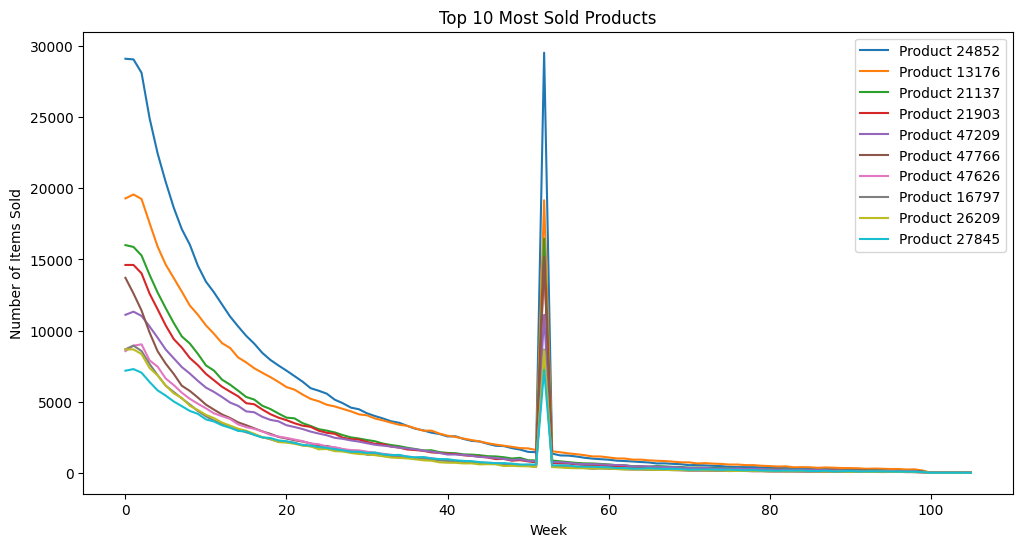

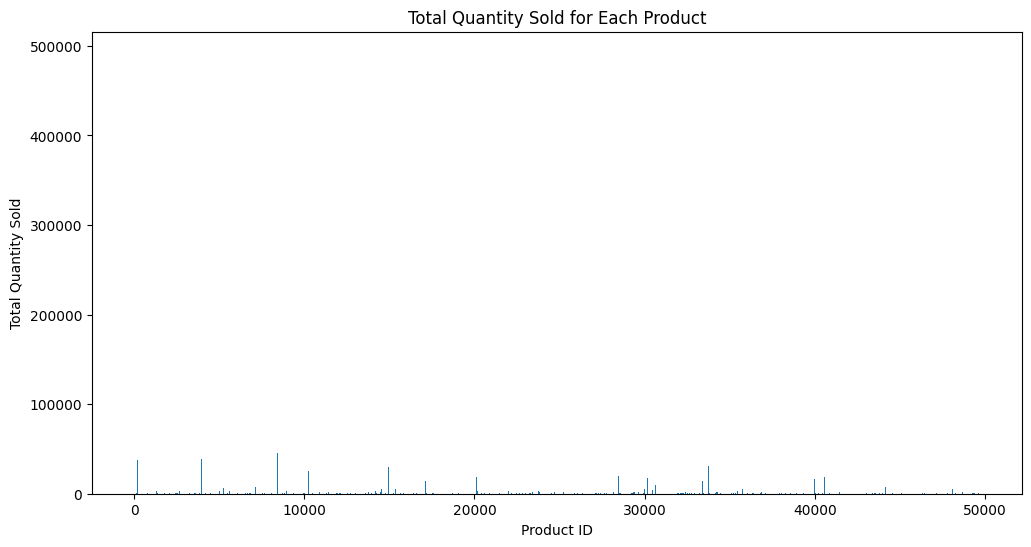

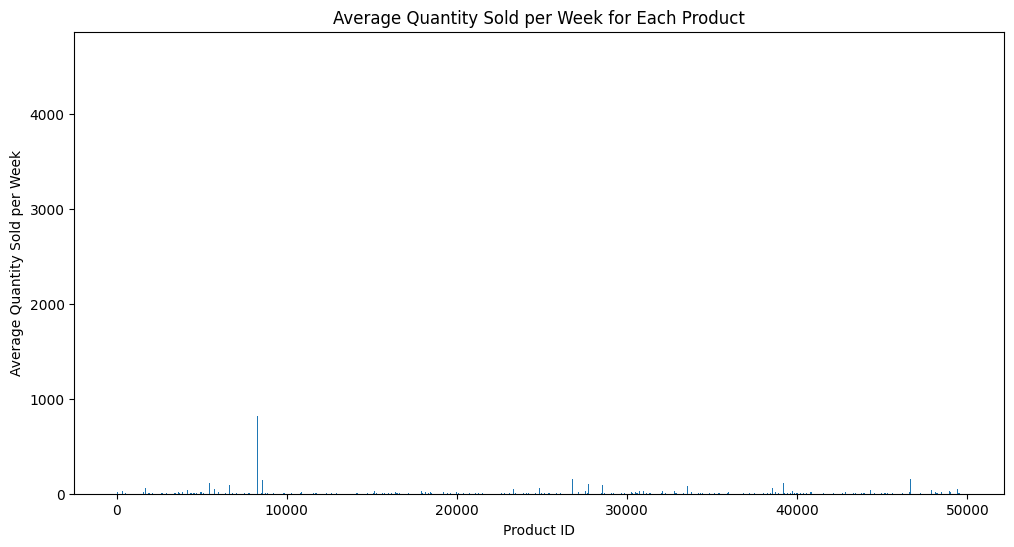

In [4]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

def explore(historical_orders_array):
    # Reshape the array to have product_id as the first dimension
    reshaped_array = historical_orders_array.reshape(-1, historical_orders_array.shape[-1])

    # Calculate the total quantity sold for each product
    total_quantity_sold = reshaped_array.sum(axis=0)

    # Find the top 10 most sold products
    top_10_products = total_quantity_sold.argsort()[-10:][::-1]

    # Plot the number of items sold over the weeks for the top 10 products
    plt.figure(figsize=(12, 6))
    for product_id in top_10_products:
        product_data = reshaped_array[:, product_id]
        plt.plot(range(len(product_data)), product_data, label=f"Product {product_id + 1}")
    plt.xlabel("Week")
    plt.ylabel("Number of Items Sold")
    plt.title("Top 10 Most Sold Products")
    plt.legend()
    plt.show()

    # Additional data exploration: Plot the total quantity sold for each product
    plt.figure(figsize=(12, 6))
    plt.bar(range(1, len(total_quantity_sold) + 1), total_quantity_sold)
    plt.xlabel("Product ID")
    plt.ylabel("Total Quantity Sold")
    plt.title("Total Quantity Sold for Each Product")
    plt.show()

    # Additional data exploration: Calculate and plot the average quantity sold per week for each product
    average_quantity_sold = reshaped_array.mean(axis=0)
    plt.figure(figsize=(12, 6))
    plt.bar(range(1, len(average_quantity_sold) + 1), average_quantity_sold)
    plt.xlabel("Product ID")
    plt.ylabel("Average Quantity Sold per Week")
    plt.title("Average Quantity Sold per Week for Each Product")
    plt.show()


def main():
    csv_file = 'historical_orders.csv'
    numpy_file = 'historical_orders.npy'

    if os.path.exists(csv_file):
        # Load the historical orders data from the CSV file if it exists
        historical_orders_df = pd.read_csv(csv_file)
        print("Historical orders data loaded from 'historical_orders.csv'.")
    else:
        # Read the CSV files
        orders_df = pd.read_csv('../instacart_data/orders.csv')
        prior_products_df = pd.read_csv('../instacart_data/order_products__prior.csv')
        train_products_df = pd.read_csv('../instacart_data/order_products__train.csv')

        # Combine the order products DataFrames
        order_products_df = pd.concat([prior_products_df, train_products_df])

        # Merge the orders and order products DataFrames
        merged_df = pd.merge(orders_df, order_products_df, on='order_id')

        # Create a hypothetical start date for the orders
        start_date = datetime(2021, 1, 1)  # Assuming the orders start from January 1, 2021

        # Calculate the order date for each order based on the start date and order_number
        merged_df['order_date'] = merged_df.apply(lambda x: start_date + timedelta(days=(x['order_number'] - 1) * 7), axis=1)

        # Extract the year and week number from the order date
        merged_df['year'] = merged_df['order_date'].dt.year
        merged_df['week'] = merged_df['order_date'].dt.isocalendar().week

        # Group by year, week, and product_id to get the total quantity purchased for each product in each week
        historical_orders_df = merged_df.groupby(['year', 'week', 'product_id']).size().reset_index(name='quantity')

        # Save the historical orders DataFrame to a CSV file
        historical_orders_df.to_csv(csv_file, index=False)
        print("Historical orders data saved to 'historical_orders.csv'.")

    if os.path.exists(numpy_file):
        historical_orders_array = np.load(numpy_file)
    else:
        # Create a MultiIndex for all possible combinations of year, week, and product_id
        years = historical_orders_df['year'].unique()
        weeks = historical_orders_df['week'].unique()
        product_ids = range(1, 49689)  # All possible product IDs from 1 to 49688
        multi_index = pd.MultiIndex.from_product([years, weeks, product_ids], names=['year', 'week', 'product_id'])

        # Transform the historical orders data into a NumPy array of the form year x week x product_id
        historical_orders_array = historical_orders_df.set_index(['year', 'week', 'product_id']).reindex(multi_index, fill_value=0).values.reshape(-1, len(weeks), len(product_ids))

        print("Historical orders array shape:", historical_orders_array.shape)

        # Save the historical orders array as a NumPy binary file
        np.save(numpy_file, historical_orders_array)
        print("Historical orders array saved as 'historical_orders.npy'.")

        
    explore(historical_orders_array)

if __name__ == '__main__':
    main()